`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

## Notes
* This notebook has implementations of `Backprop`, `feedback alignment` (random backprop), `direct feedback alignment` and `feedforward` updates for a neural net with 1 hidden layer, `softmax` and `tanh/sigmoid` activations for output and hidden layers respectively  and `cross entropy` function. In this case we code backprop using `tf.gradients` method. `tf.gradients` method is useful when you want to code a generic neural network but when you want to do something special like Random backprop or Feed Forward updates (for more on this see reference 1) then you might have to code the network using basic tensorflow operations. This notebook illustrates how to code a basic fully connected network using `tf.gradients` and also by using already derived backprop equations.
## References
* [Randombackprop and Feedforward updates Paper](https://arxiv.org/pdf/1909.01311.pdf)
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`.

In [1]:
import os, time, IPython
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-au1g1qav because the default path (/home/visionteam/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
print(tf.__version__)
tf

1.15.0


<module 'tensorflow' from '/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow/__init__.py'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plot settings

In [3]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
batch_size = 10
iterations = 20000
epochs = int((iterations*batch_size) / (mnist.train.images.shape[0]))
print('Total number of epochs:{}'.format(epochs))

Total number of epochs:3


In [7]:
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the graph for backprop

In [8]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

n_middle = 500
with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_middle,784], stddev=0.01),name = 'W_2')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))


with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    #d_z_3 = tf.gradients(cost, z_3)[0]
    #d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
    d_w_3 = tf.gradients(cost, w_3,name='delta_w3')[0]
    d_b_3 = tf.gradients(cost, b_3,name='delta_b3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    #d_z_2 = tf.multiply(tf.matmul(tf.transpose(w_3),d_z_3, name = 'w_3Txdelta3'), sigmaprime(z_2), name = 'delta2')
    #d_b_2 = d_z_2
    #d_w_2 = tf.matmul(d_z_2,tf.transpose(a_1), name = 'delta_w2')
    
    d_w_2 = tf.gradients(cost, w_2,name='delta_w2')[0]
    d_b_2 = tf.gradients(cost, b_2,name='delta_b2')[0]
    
eta = tf.constant(0.075)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Exercise

* You'll notice that there is a memory leak in GPU and it's because of the line in the below cell

`best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]), tf.assign(b_3,best_params[1][1])]` 

* The above line was used to fix the weights of the network with the best validation weights to test on it.

* Tensorflow sees that line as we are adding a new variable to tensorflow graph everytime we execute it. Instead we need to define an update operation in the above cell for each of the variables (biases and weights) and use that to update the weights and biases. Something like:
    
`w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2') 
 w_2_update_op = w_2.assign(w_2_update_placeholder)` 
      
* And then use `sess.run(w_2_update_op, {w_2_update_placeholder:best_params[0][0]})` to re-wire the network. 

* For more info [see](https://github.com/tensorflow/tensorflow/issues/4151)


### Train backprop

In [9]:
train_accuracies = []
train_costs = []
val_accuracies = []
val_costs = []
best_val = 0
best_params = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    sess.run(step, feed_dict = {a_1: batch_xs,y:batch_ys}, 
             options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format(int(i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies.append(val_acc / 5000.0)
        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
    tf.assign(b_3,best_params[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.3086986541748047 and training accuracy:0.11856363636363636
validation cost:2.310991048812866 and validation accuracy:0.1106
Epoch:1
training cost:0.4673917293548584 and training accuracy:0.8751818181818182
validation cost:0.4461158812046051 and validation accuracy:0.8802
Epoch:2
training cost:0.3715985417366028 and training accuracy:0.8955454545454545
validation cost:0.3523395359516144 and validation accuracy:0.9022
Epoch:3
training cost:0.3456161320209503 and training accuracy:0.9004727272727273
validation cost:0.3275323808193207 and validation accuracy:0.906
Final test accuracy is:0.9116
Test accuracy corresp to best val acc:0.9057


### Plots

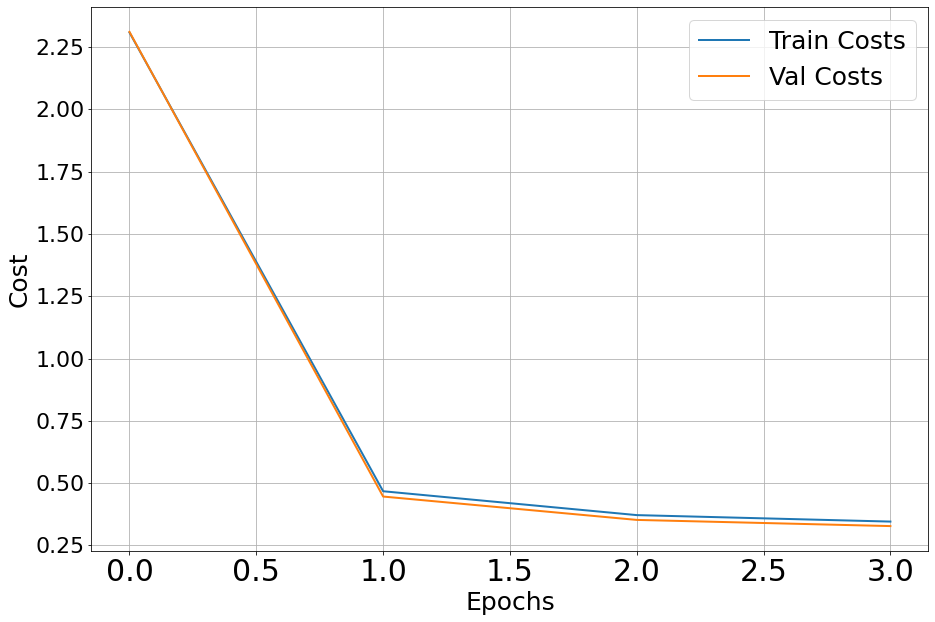

In [10]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

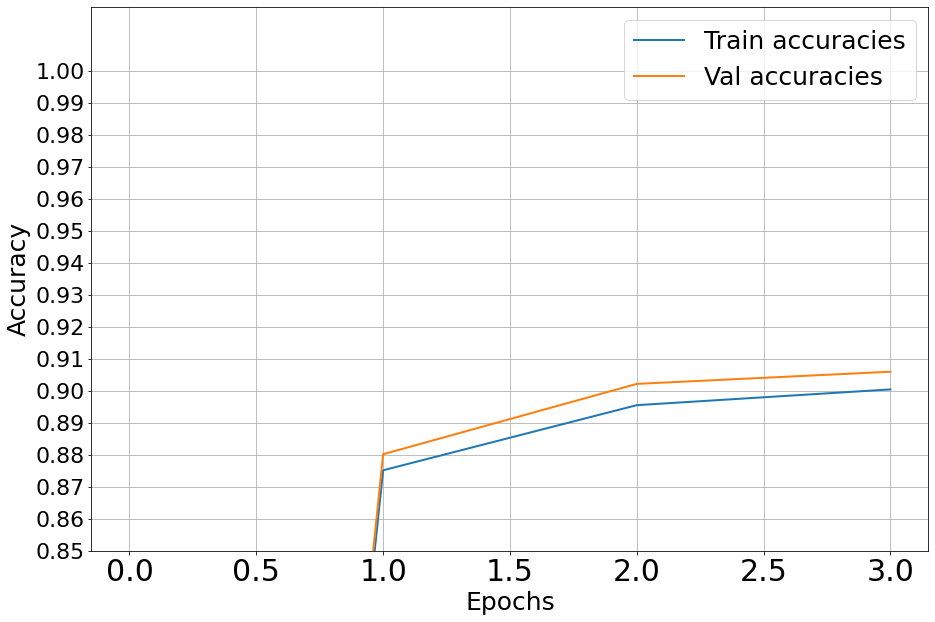

In [11]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.85,1.02)
plt.grid()
plt.legend()
plt.show()

## Setup the graph for Feedback alignment (Random backprop or FA)

In [12]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [13]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    w_2_r = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2_r')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    #w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    #w_3_r = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_r')
    w_3_r = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3_r')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    d_z_3 = tf.gradients(cost,z_3)[0]
    d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    d_w_3 = tf.gradients(cost,w_3, name='delta_w3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    ### random backprop (NOTICE THAT WE'RE USING A FIXED RANDOM MATRIX w_3_r TO CALCULATE d_z_2 (delta2))
    #d_z_2_r = tf.multiply(tf.matmul(tf.transpose(w_3_r),d_z_3, name = 'w_3_rTxdelta3'), sigmaprime(z_2), 
    #                      name = 'delta2_r')
    d_z_2_r = tf.multiply(tf.matmul(tf.transpose(w_3_r),d_z_3, name = 'w_3_rTxdelta3'), tf.gradients(a_2,z_2)[0], 
                          name = 'delta2_r')
    d_b_2_r = d_z_2_r
    d_w_2_r = tf.matmul(d_z_2_r,tf.transpose(a_1), name = 'delta_w2_r')

step_r = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_r)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_r, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Train feedback alignment

In [14]:
train_accuracies_r = []
train_costs_r = []
val_accuracies_r = []
val_costs_r = []
best_val_r = 0
best_params_r = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_r, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format(int(i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_r.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_r.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_r.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_r.append(val_acc / 5000.0)
        if(val_acc>best_val_r):
            best_val_r = val_acc
            best_params_r = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_r[0][0]), tf.assign(b_2,best_params_r[0][1]),tf.assign(w_3,best_params_r[1][0]),\
    tf.assign(b_3,best_params_r[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.316180944442749 and training accuracy:0.10009090909090909
validation cost:2.3159615993499756 and validation accuracy:0.0922
Epoch:1
training cost:0.5208898186683655 and training accuracy:0.865909090909091
validation cost:0.4999586343765259 and validation accuracy:0.8746
Epoch:2
training cost:0.43216705322265625 and training accuracy:0.8806545454545455
validation cost:0.4101530909538269 and validation accuracy:0.8866
Epoch:3
training cost:0.39562180638313293 and training accuracy:0.8895272727272727
validation cost:0.3743061423301697 and validation accuracy:0.8974
Final test accuracy is:0.902
Test accuracy corresp to best val acc:0.8978


### Plots

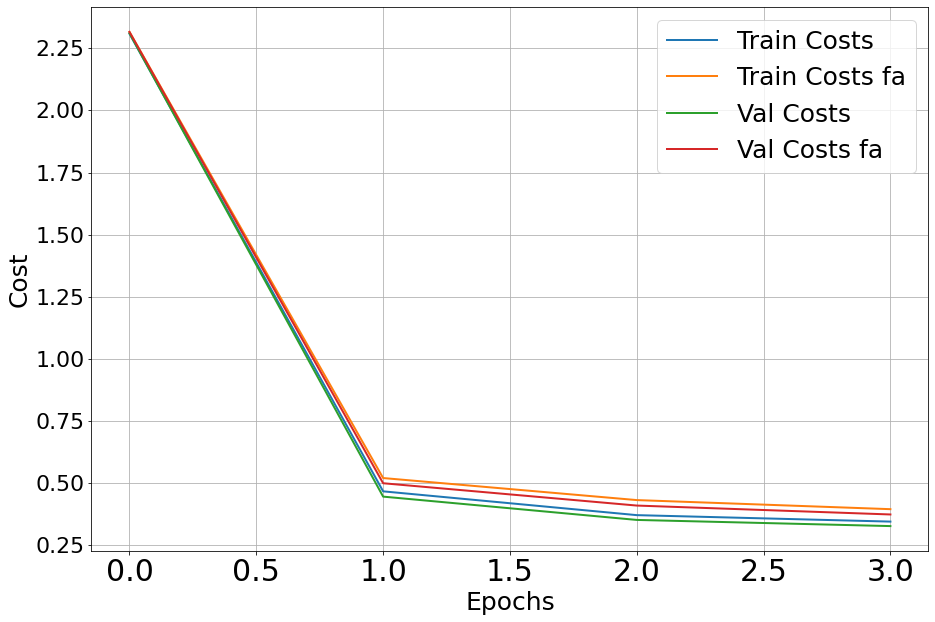

In [15]:
plt.plot(train_costs, label="Train Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs, label="Val Costs")
plt.plot(val_costs_r, label="Val Costs fa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

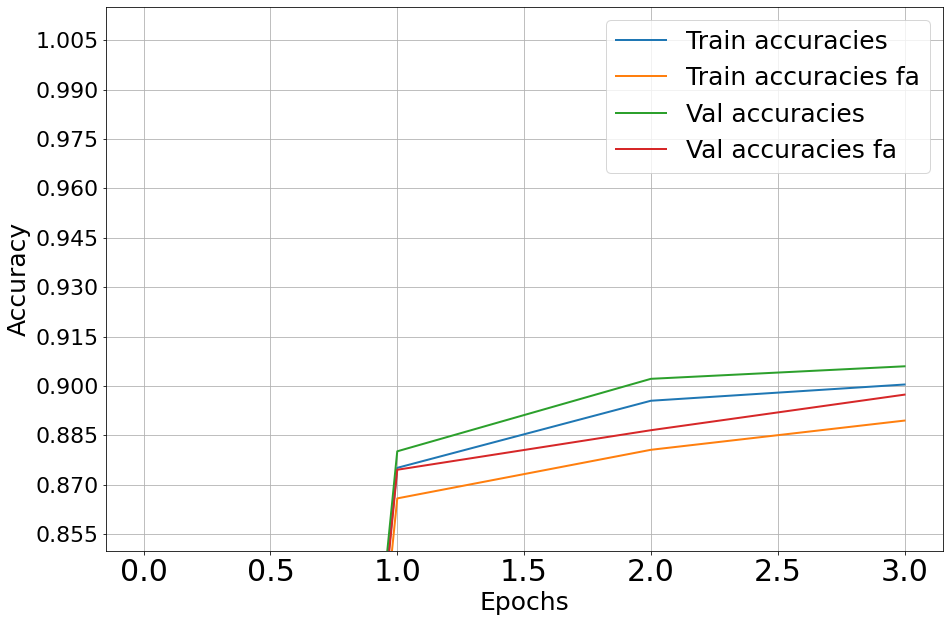

In [16]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies, label="Val accuracies")
plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,80)])
plt.ylim(0.85,1.015)
plt.grid()
plt.legend()
plt.show()

## Setup the graph for Feedforward updates (FF)


In [17]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [18]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    low_ff = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high_ff = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_2_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low_ff,maxval=high_ff), name = 'W_2_df')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    #w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    #w_3_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_df')
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    w_3_ff = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3_ff')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))


with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    d_z_3 = tf.gradients(cost,z_3,name = 'delta3')[0]
    d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    d_w_3 = tf.gradients(cost,w_3, name='delta_w3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    d_z_2_ff = tf.multiply(tf.matmul(tf.transpose(w_2_ff),y, name = 'w_2_ffTxy'), sigmaprime(z_2), 
                          name = 'delta2_ff') #<-- NOTICE THAT WE'RE USING LABELS!! AND NOT THE ERRORS FROM 
                                            # TOWARDS THE OUTPUT DIRECTION
    d_b_2_ff = d_z_2_ff
    d_w_2_ff = tf.matmul(d_z_2_ff,tf.transpose(a_1), name = 'delta_w2_ff')

step_ff = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_ff)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_ff, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

### Train feedforward

In [19]:
train_accuracies_ff = []
train_costs_ff = []
val_accuracies_ff = []
val_costs_ff = []
best_val_ff = 0
best_params_ff = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_ff, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format(int(i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_ff.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_ff.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_ff.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_ff.append(val_acc / 5000.0)
        if(val_acc>best_val_ff):
            best_val_ff = val_acc
            best_params_ff = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_ff[0][0]), tf.assign(b_2,best_params_ff[0][1]),tf.assign(w_3,best_params_ff[1][0]),\
    tf.assign(b_3,best_params_ff[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.3043277263641357 and training accuracy:0.11316363636363637
validation cost:2.303570032119751 and validation accuracy:0.1132
Epoch:1
training cost:0.33753132820129395 and training accuracy:0.8952181818181818
validation cost:0.3164449632167816 and validation accuracy:0.9028
Epoch:2
training cost:0.29293638467788696 and training accuracy:0.9093272727272728
validation cost:0.27337998151779175 and validation accuracy:0.9164
Epoch:3
training cost:0.26754122972488403 and training accuracy:0.9164545454545454
validation cost:0.2493976354598999 and validation accuracy:0.9238
Final test accuracy is:0.9212
Test accuracy corresp to best val acc:0.9203


### Plots

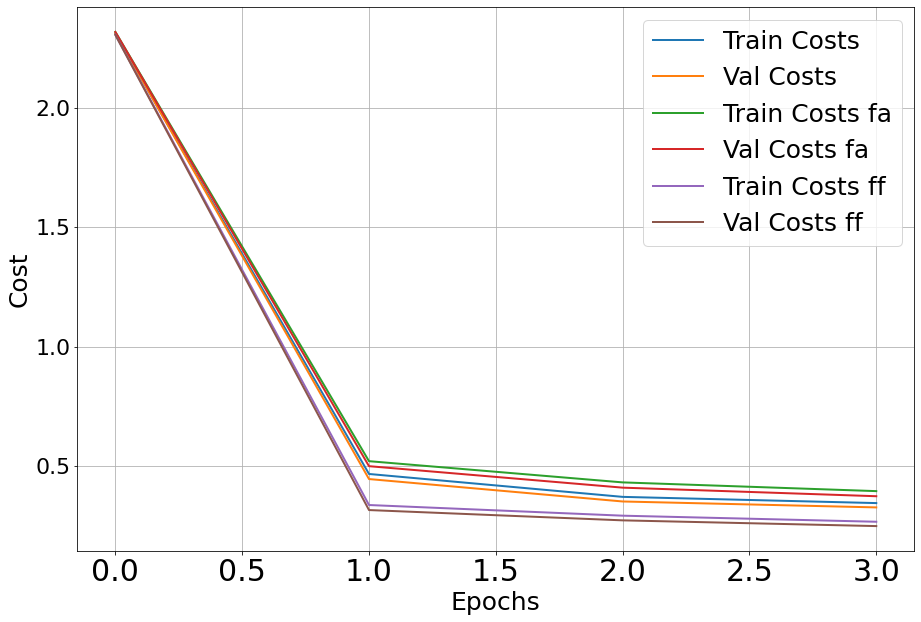

In [23]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs_r, label="Val Costs fa")
plt.plot(train_costs_ff, label="Train Costs ff")
plt.plot(val_costs_ff, label="Val Costs ff")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

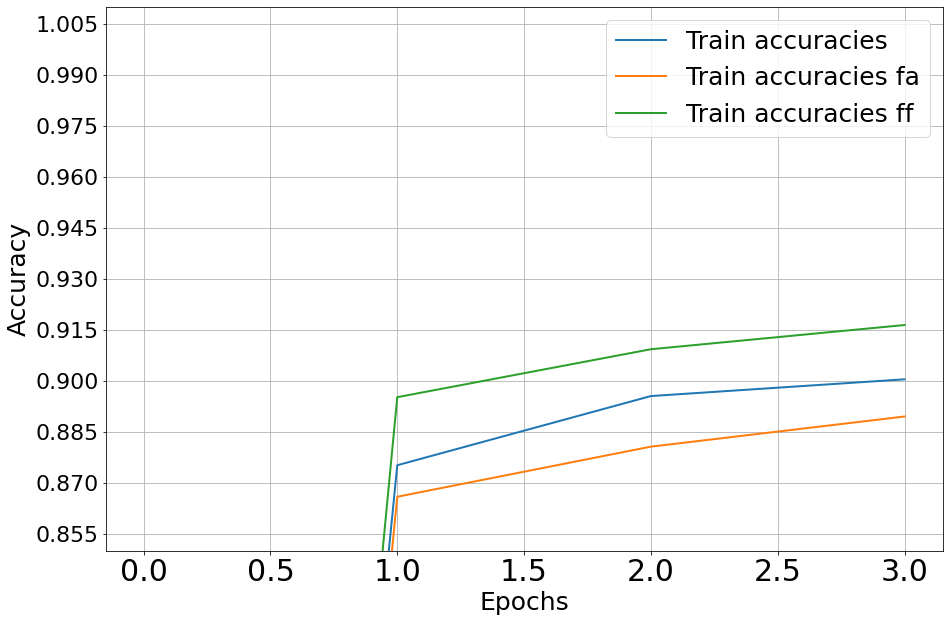

In [24]:
plt.plot(train_accuracies, label="Train accuracies")
#plt.plot(val_accuracies, label="Val accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
#plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(val_accuracies_df, label="Val accuracies dfa")
plt.plot(train_accuracies_ff, label="Train accuracies ff")
#plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,95)])
plt.ylim(0.85,1.01)
plt.grid()
plt.legend()
plt.show()

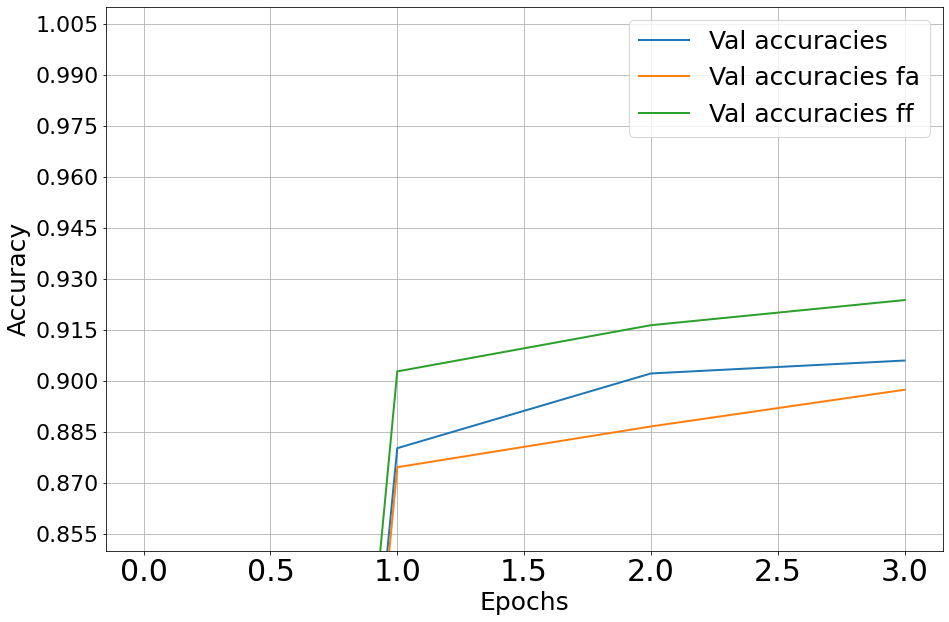

In [25]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
#plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(train_accuracies_df, label="Train accuracies dfa")
#plt.plot(train_accuracies_ff, label="Train accuracies ff")
plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,95)])
plt.ylim(0.85,1.01)
plt.grid()
plt.legend()
plt.show()

## Restart the notebook to free up the `GPU` and `RAM`

In [ ]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

### Exercise
* Read more about [chrome-tracing](https://towardsdatascience.com/howto-profile-tensorflow-1a49fb18073d) and implement it.

In [ ]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()